# Keras Tuner - Hyperparameters search on Multiclass Obesity Risk dataset

<div class="alert alert-block alert-warning">
This Notebbok is setup to execute Keras_Tuner for search for best hyperparameters<br> - setup to search only for '9'

<b>Even on '9' takes a long time to execute</b>
</div>

<div class="alert alert-block alert-info">
  Notebok describes the setup and execution of Keras Tuner to analyze Neural Network and tune hyperparameters to come up with the best accuracy against a dataset.<br>

  <br>Similar to a a graduate student's research on an upcoming thesis or presentation, I came up with a set of hyperparameters manually varying parameters one or few at a time (this is a very laborious process - enjoyed and at the same time learned a lot on how each parameter affect generalization and accuracy) and executing tests to understand the interactions and their effects on the model.

  In Netural Networks most important is to get the dataset to a stage that is well understood by the model. 
  
  All categoricals must be normalized - what is the best standardization to achieve this? (I am still figuring out), but the best one I found to date is, <b>Power Transformer</b> from Scikit-Learn ML package. This is in addition to good Exploratory Data Analysis - a must for good inference.
  
  Next is setting up a good Neural Network Architecture
  <ul>
  <li>Depends on the input data, number of samples (if number of samples is less, go with less number of hidden layers and less number of Neurons per layer -or- augment (posted one such technique in this Notebook - ref: barbagrande007)
  <li>Include Dropouts (this is one form of regularization)
  <li>Include BatchNormalization - this follows a Dropout layer (another regularization technique).
  </ul>
    All Hyperparameters affect overfitting/underfitting. Once you find a good set that gets you to 80+% accuracy. Use this as a <b>BASE</b> model to tune hyperparameters.
  
  The spread of various hyperparameters you plan to search on, suggest to be +/- 20% from your base model values

  I could not find much info on how to setup Keras_Tuner to hypertune EPOCHS, but I did find a way to setup EPOCHS and have Keras_Tuner hypertune epochs.

</div>

<HR>
In this notebook will be using the 

[<b>Multi-Class Prediction of Obesity Risk</b>](https://www.kaggle.com/competitions/playground-series-s4e2) dataset.
<hr>

<div class="alert alert-block alert-warning">
<b>Accuracy is only as good as the dataset that is used to train the <u>Keras Deep Neural Network model</u></b><br>

To learn more about <b>Keras_Tuner</b>, please access the links posted below. In addition there is also good documentation and use models on Keras_Tuner
</div>

<div class="alert alert-block alert-info">
<b>References:</b>

[hyperparameter-tuning-with-keras-tuner](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)  
[getting_started with Keras-Tuner](https://keras.io/guides/keras_tuner/getting_started/)  
[coderzcolumn - Keras-Tuner](https://coderzcolumn.com/tutorials/artificial-intelligence/keras-tuner-hyperparameters-tuning-of-keras-models)  
[Notebook on Google Colab](https://colab.research.google.com/github/keras-team/keras-io/blob/master/guides/ipynb/keras_tuner/custom_tuner.ipynb)
</div>

<div class="alert alert-block alert-info">

<b>This Notebook setups hyperparameter search over only on '9' parameters</b>

<ul>
    <li>batch_sizes - same is referenced in 'HyperTuningNetwork' class but name is different</li>
    <li>epoch_sizes - number of epochs in run</li>
    <li>units - Number of Neurons in first fully connected Dense layer</li>
    <li>units1 - A float to scale the number of neurons in layer1 and use as Number of Neurons in second fully connected Dense layer</li>
    <li>l2_reg - Float - value of Kernel_regularizer - L2</li>
    <li>learning_rate - To setup learning_rate_scheduler for Adam - Model optimizer</li>
    <li>decay_steps - To setup learning_rate_scheduler for Adam - Model optimizer</li>
    <li>decay_rate - To setup learning_rate_scheduler for Adam - Model optimizer</li>
  </ul>

</div>

## import packages

In [1]:
# Notebook uses PowerTransformer scaling - version of scikit-learn package must be higher than 1.2.2
!pip install scikit-learn>=1.2.4 --upgrade
import sklearn as sk
sk.__version__

'1.4.0'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%autosave 60
# import kaggle
from datetime import datetime

pd.set_option('display.max_columns', None)

Autosaving every 60 seconds


In [3]:
import os
import shutil
import sys
from glob import glob
import re
import math

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import to_categorical

# preprocessing and model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# metrics and utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight, compute_sample_weight

import scipy

2024-02-15 07:14:59.322263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 07:14:59.322343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 07:14:59.324039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[1:],'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('setting session for memory growth')
    except:
        pass

<div class="alert alert-block alert-info">
<b>This Notebook</b> does not emphasis much on <b>Exploratory Data Analysis</b>, but focuses on highlighting the use-model of Keras-Tuner
</div>

## datasets splits before analysis

In [7]:
# download dataset
# If you are on Kaggle go to competition page and create a notebook
# -OR- if Kaggle is setup at home, please download dataset
# !kaggle competitions download -c playground-series-s4e2

In [8]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')

In [9]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

In [10]:
# print columns to check
print(f'train_df columns:{train_df.columns} \n test_df columns:{test_df.columns}')

train_df columns:Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object') 
 test_df columns:Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype='object')


<div class="alert alert-block alert-info">Get list of category columns from train and test datasets and check if the unique values match
  <br><b>do not check the 'ground truth' column</b>

</div>

In [11]:
train_cat_cols = train_df.select_dtypes(include=['object', 'category'])
test_cat_cols = test_df.select_dtypes(include=['object', 'category'])

In [12]:
# check unique values in Category columns - must be equal
for i in train_cat_cols.columns:
  if i in test_df.columns:
    try:
      if not np.array_equal( np.sort(np.unique(train_df[i])), 
                            np.sort(np.unique(test_df[i]))):
        print('\n#####Column:', i , 'elements are not equal ######')
        print('Train:', np.sort(np.unique(train_df[i])), 
              '\nTest:', np.sort(np.unique(test_df[i])), end='\n\n')
      else:
        print('\nColumn:', i , '\nTrain:', np.sort(np.unique(train_df[i])), 
              '\nTest:', np.sort(np.unique(test_df[i])))
    except: 
        pass
  else:
    print('\nColumn:', i , 'does not exist in test_df', end='\n\n')




Column: Gender 
Train: ['Female' 'Male'] 
Test: ['Female' 'Male']

Column: family_history_with_overweight 
Train: ['no' 'yes'] 
Test: ['no' 'yes']

Column: FAVC 
Train: ['no' 'yes'] 
Test: ['no' 'yes']

Column: CAEC 
Train: ['Always' 'Frequently' 'Sometimes' 'no'] 
Test: ['Always' 'Frequently' 'Sometimes' 'no']

Column: SMOKE 
Train: ['no' 'yes'] 
Test: ['no' 'yes']

Column: SCC 
Train: ['no' 'yes'] 
Test: ['no' 'yes']

#####Column: CALC elements are not equal ######
Train: ['Frequently' 'Sometimes' 'no'] 
Test: ['Always' 'Frequently' 'Sometimes' 'no']


Column: MTRANS 
Train: ['Automobile' 'Bike' 'Motorbike' 'Public_Transportation' 'Walking'] 
Test: ['Automobile' 'Bike' 'Motorbike' 'Public_Transportation' 'Walking']

Column: NObeyesdad does not exist in test_df



<div class="alert alert-block alert-info">check duplicates in train_df - assuming no duplicates in test_df</div>

In [13]:
train_df.duplicated().sum()

0

# Combine both dataframes to scale and transform

<div class="alert alert-block alert-info">combine the dataframes and onehot encode categorical columns, since test dataset has an extra unique value in one of the columns</div>

In [14]:
# capture train_df.NObeyesdad to a Series and remove from train_df
# test_df does not have this column
train_Y = train_df.NObeyesdad
train_df.drop(['NObeyesdad'], axis=1, inplace=True)

# capture 'id' of test_df for use later
test_id = test_df.id

# combine both dataframes to one-hotencode
frames = [train_df, test_df]
combined_df = pd.concat(frames)

In [15]:
# check stats - remove semi-colon at end and wrap in print statement
combined_df.describe().transpose();

In [16]:
combined_df.info();

<class 'pandas.core.frame.DataFrame'>
Index: 34598 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34598 non-null  int64  
 1   Gender                          34598 non-null  object 
 2   Age                             34598 non-null  float64
 3   Height                          34598 non-null  float64
 4   Weight                          34598 non-null  float64
 5   family_history_with_overweight  34598 non-null  object 
 6   FAVC                            34598 non-null  object 
 7   FCVC                            34598 non-null  float64
 8   NCP                             34598 non-null  float64
 9   CAEC                            34598 non-null  object 
 10  SMOKE                           34598 non-null  object 
 11  CH2O                            34598 non-null  float64
 12  SCC                             34598

In [17]:
combined_df.isnull().sum();

<div class="alert alert-block alert-info">Combine both datasets and onehot-encode</div> 

In [18]:
combined_df = pd.get_dummies(combined_df)
type(combined_df), combined_df.shape, combined_df.columns

(pandas.core.frame.DataFrame,
 (34598, 32),
 Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
        'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
        'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
        'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
        'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
        'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
        'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
        'MTRANS_Walking'],
       dtype='object'))

In [19]:
# check first few rows of encoded dataset
combined_df.head()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


In [20]:
# Now get back test and train datasets from combined_df before scaling
test_dum = combined_df[combined_df.id.isin(test_id)]

In [21]:
type(test_dum), test_dum.shape, test_dum.columns

(pandas.core.frame.DataFrame,
 (13840, 32),
 Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
        'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
        'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
        'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
        'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
        'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
        'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
        'MTRANS_Walking'],
       dtype='object'))

In [22]:
test_dum.head()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,20758,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,20759,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
2,20760,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
3,20761,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,20762,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


In [23]:
train_dum = combined_df[~combined_df['id'].isin(test_id)]

In [24]:
type(train_dum), train_dum.shape, train_dum.columns

(pandas.core.frame.DataFrame,
 (20758, 32),
 Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
        'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
        'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
        'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
        'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
        'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
        'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
        'MTRANS_Walking'],
       dtype='object'))

In [25]:
train_dum.head()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


<div class="alert alert-block alert-info">function to split trainXY and test_X</div>

In [26]:
def create_datasets(trainxy, testx):
    # capture test_ids
    submit_id = testx['id']

    # Remove 'id' from dataseta
    testx = testx.drop(['id'], axis=1)
    trainx = trainxy.drop(['id'], axis=1)

    # split train_XY into train_X and train_Y
    # this columns is already removed - no return
    # trainy = trainx.NObeyesdad
    # trainx.drop(['NObeyesdad'], axis=1, inplace=True)

    # return trainx, trainy, testx, submit_id
    return trainx, testx, submit_id

<div class="alert alert-block alert-info">call function create_datasets to split back to original rows but with encoded columns</div>

In [27]:
train_X, test_X, test_id = create_datasets(train_dum, test_dum)

# Initial Data Explortion

In [28]:
type(train_X), train_X.shape, train_X.columns

(pandas.core.frame.DataFrame,
 (20758, 31),
 Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
        'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
        'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
        'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
        'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
        'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
        'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
        'MTRANS_Walking'],
       dtype='object'))

In [29]:
type(test_X), test_X.shape, test_X.columns

(pandas.core.frame.DataFrame,
 (13840, 31),
 Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
        'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
        'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
        'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
        'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
        'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
        'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
        'MTRANS_Walking'],
       dtype='object'))

In [30]:
train_X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [31]:
train_X.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 31 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Age                                 float64
 1   Height                              float64
 2   Weight                              float64
 3   FCVC                                float64
 4   NCP                                 float64
 5   CH2O                                float64
 6   FAF                                 float64
 7   TUE                                 float64
 8   Gender_Female                       bool   
 9   Gender_Male                         bool   
 10  family_history_with_overweight_no   bool   
 11  family_history_with_overweight_yes  bool   
 12  FAVC_no                             bool   
 13  FAVC_yes                            bool   
 14  CAEC_Always                         bool   
 15  CAEC_Frequently                     bool   
 16  CAEC_Some

In [32]:
print(train_X.isnull().sum() !=0)

Age                                   False
Height                                False
Weight                                False
FCVC                                  False
NCP                                   False
CH2O                                  False
FAF                                   False
TUE                                   False
Gender_Female                         False
Gender_Male                           False
family_history_with_overweight_no     False
family_history_with_overweight_yes    False
FAVC_no                               False
FAVC_yes                              False
CAEC_Always                           False
CAEC_Frequently                       False
CAEC_Sometimes                        False
CAEC_no                               False
SMOKE_no                              False
SMOKE_yes                             False
SCC_no                                False
SCC_yes                               False
CALC_Always                     

In [33]:
print(test_X.isnull().sum() !=0)

Age                                   False
Height                                False
Weight                                False
FCVC                                  False
NCP                                   False
CH2O                                  False
FAF                                   False
TUE                                   False
Gender_Female                         False
Gender_Male                           False
family_history_with_overweight_no     False
family_history_with_overweight_yes    False
FAVC_no                               False
FAVC_yes                              False
CAEC_Always                           False
CAEC_Frequently                       False
CAEC_Sometimes                        False
CAEC_no                               False
SMOKE_no                              False
SMOKE_yes                             False
SCC_no                                False
SCC_yes                               False
CALC_Always                     

<div class="alert alert-block alert-info">plot all features</div>

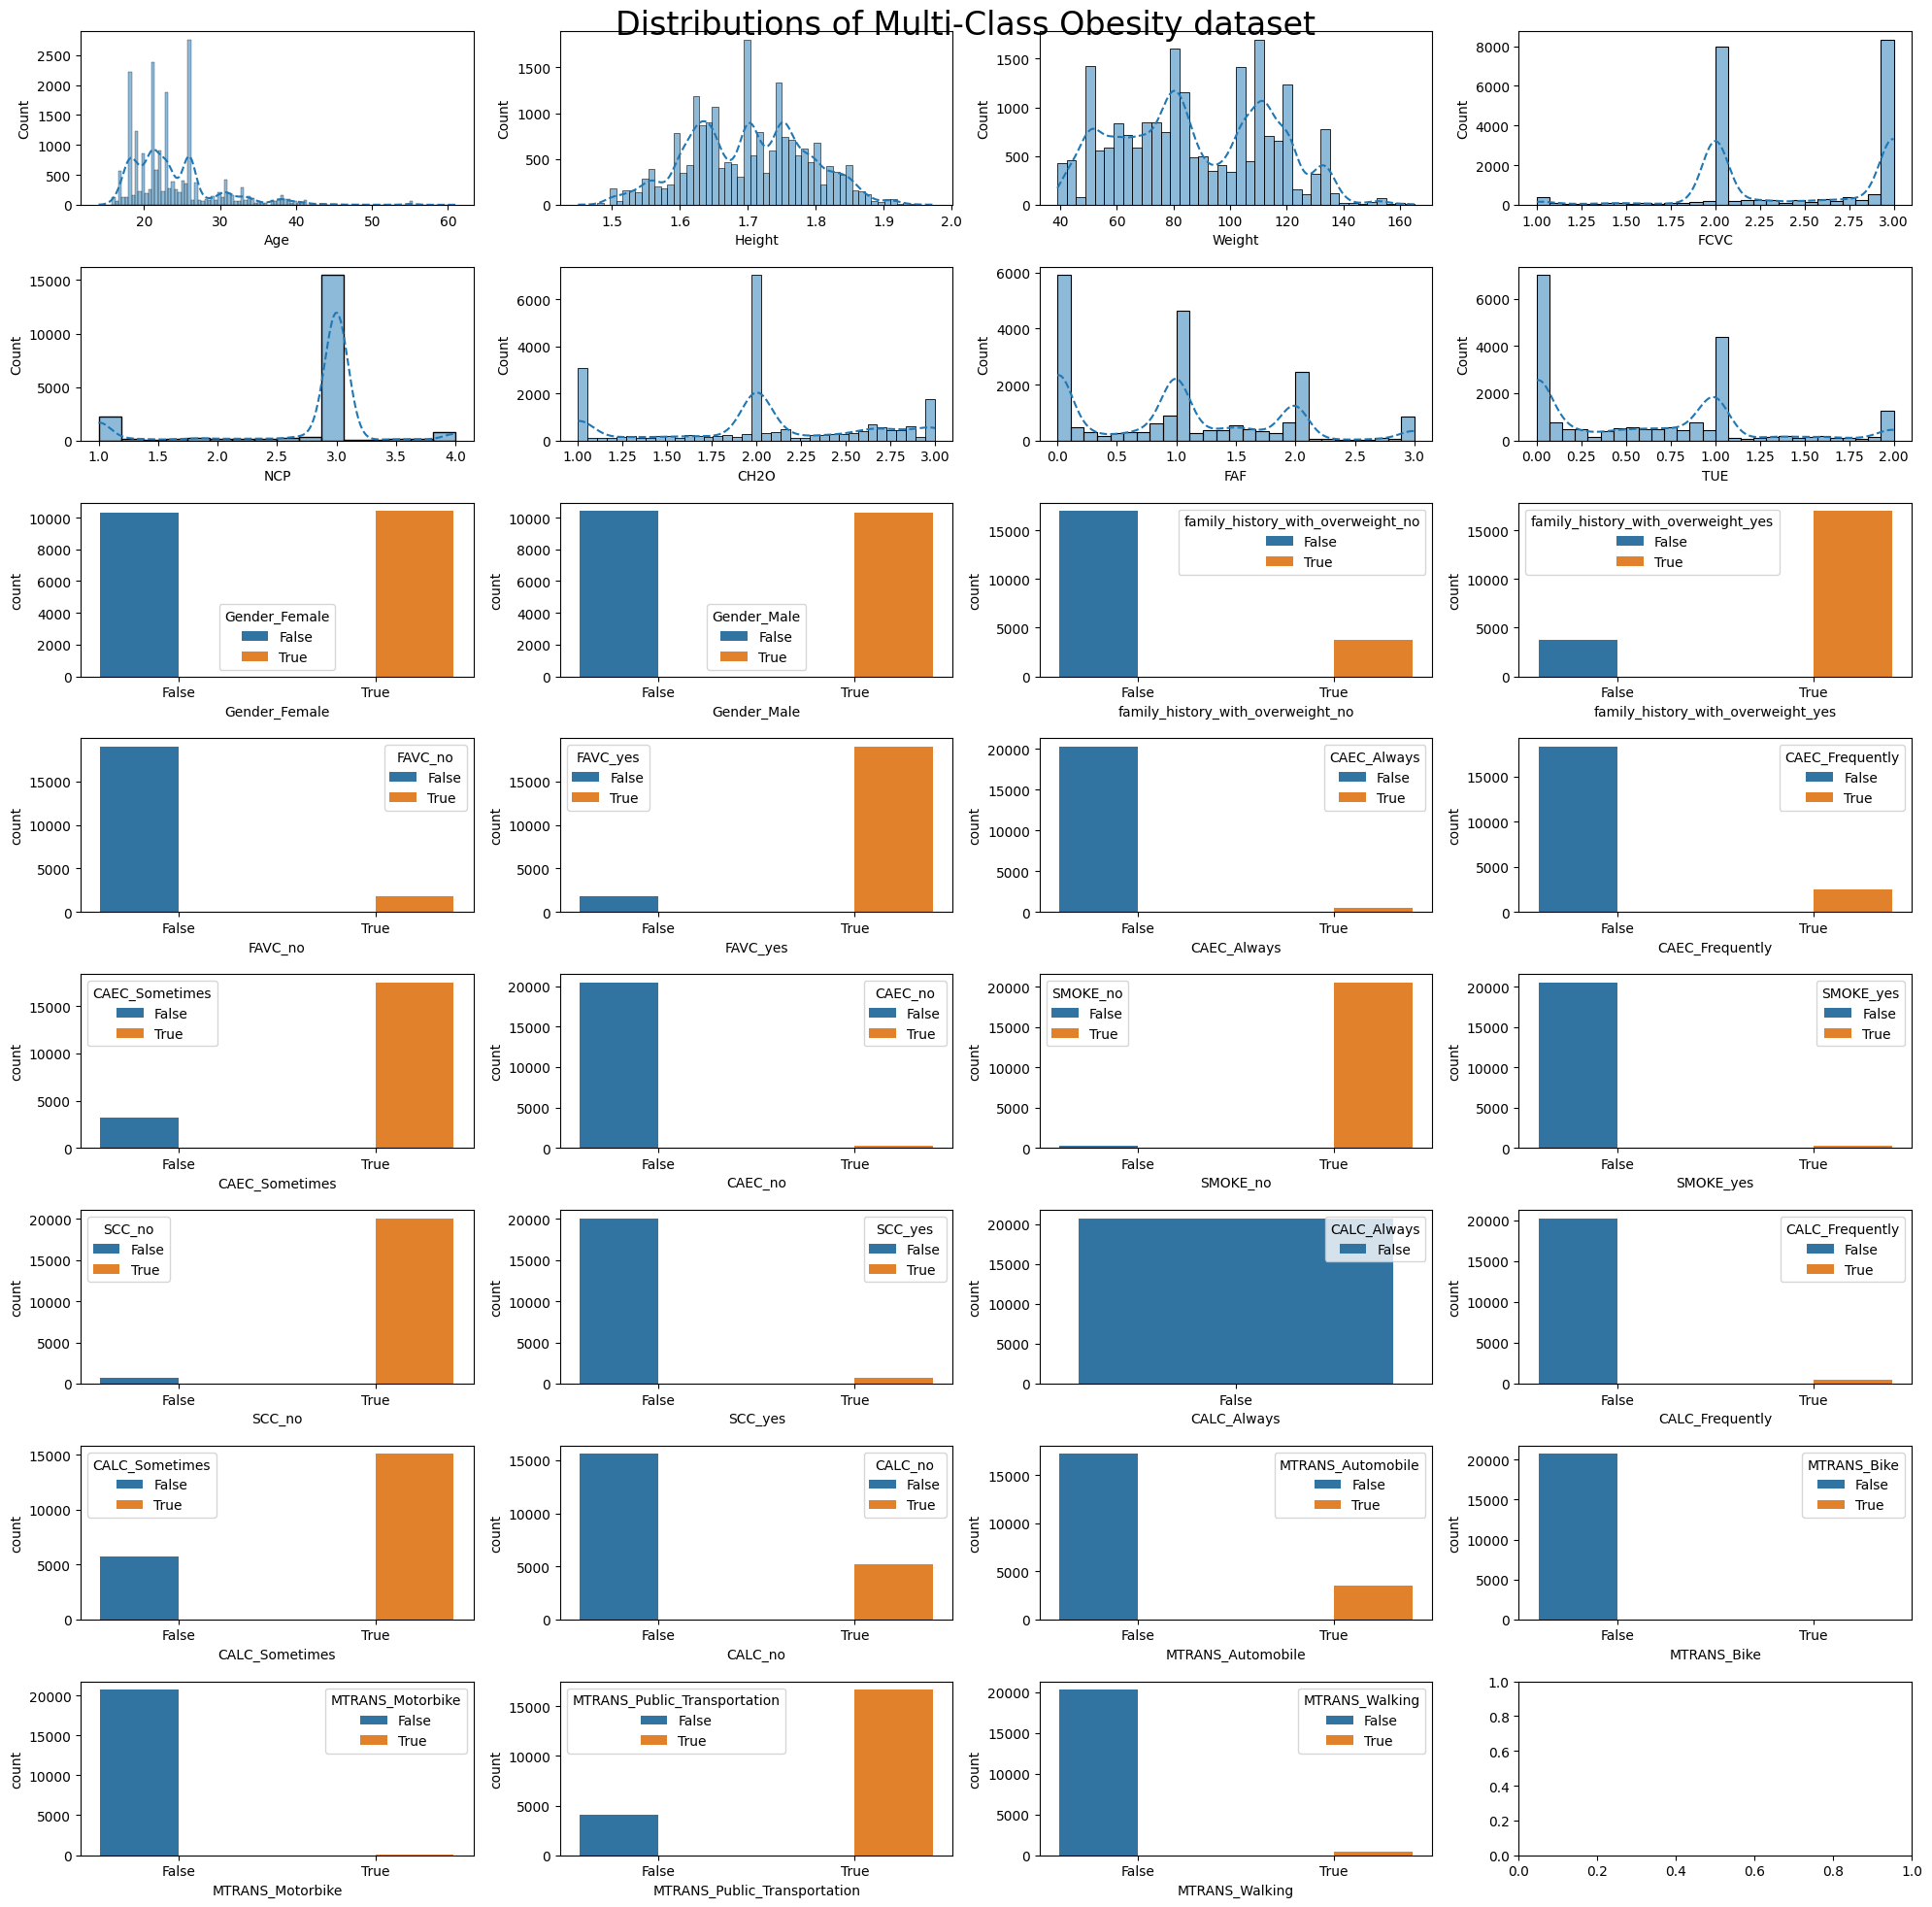

In [34]:
# Plot all features
cols = 4
rows = int(math.ceil(len(train_X.columns) / cols))

fig,ax = plt.subplots(nrows=rows,ncols=cols,figsize=(20,20))
ax = ax.flatten()

plt.suptitle("Distributions of Multi-Class Obesity dataset",size=24)

for i,col in enumerate(train_X.columns):
    if train_X[col].dtype == float or train_X[col].dtype == int:
        sns.histplot(data=train_X,x=col,ax=ax[i],kde=True,line_kws={"ls":"--"})
    else:
        sns.countplot(data=train_X,x=col,ax=ax[i], hue=col)
        # ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

# Augment - Datasets for Analysis and Prediction

## different scaling techniques

<div class="alert alert-block alert-info">
For Fully Connected Neural Networks when used to predict majority class for classification problems or predict values against continuous data<br>
<br><u>PowerTransformer</u> scaling seem to work best
<br><u>StandardScaled and/or MinMaxScaled</u> data used for inference against a Neural Netork Architecture always seem to hit a celing and can never break past

<br>The prediction -or- inference against testset (Kaggle competition) synthetically created <u>rose by <b>14.2</b> percentage point</u>
  
</div>

In [35]:
# PowerTransformer
scaler = PowerTransformer()
X = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

## end different scaling technique

In [36]:
# Create a classweight dictionary
classes = train_Y.unique()
classweight = compute_class_weight(class_weight="balanced",classes=classes,y=train_Y)

classweight_dict = {}
for idx,weight in enumerate(classweight):
    classweight_dict[idx] = weight / classweight[0]

classweight_dict

{0: 1.0,
 1: 0.81829980532122,
 2: 0.9996036464526358,
 3: 0.6233316856154226,
 4: 0.7764778325123152,
 5: 1.0391429748660899,
 6: 0.8666666666666666}

<div class="alert alert-block alert-info">label encoding and converting to onehot categorical using Keras to_categorical package</div>

In [37]:
labelEnc = LabelEncoder()
y_encoded = labelEnc.fit_transform(train_Y)

y = tf.keras.utils.to_categorical(y_encoded)

<div class="alert alert-block alert-info">
<b>Ref:</b>

[barbagrande007](https://www.kaggle.com/code/barbagrande007/bbg007-s4e2-obesity)

<br>Add jittering. Introduce noise to X to increase data size, similar to image augmentation techniques in Convolutional Neural Networks.
  <ul>
  <li>Creates more training samples
  <li>decreases overfitting
  <li>improves accuracy and predictability
  </ul>
  
</div>

In [38]:
X_jitter1 = X + np.random.uniform(0, 0.05, size=X.shape)
X_jitter2 = X + np.random.uniform(0, 0.1, size=X.shape)
X_jitter3 = X + np.random.uniform(0, 0.15, size=X.shape)
X_jitter4 = X + np.random.uniform(0, 0.2, size=X.shape)
X = np.vstack((X,X_jitter1,X_jitter2,X_jitter3,X_jitter4))

# Duplicate y
y = np.vstack((y,y,y,y,y))

# Randomize samples
shuffled_indices = np.random.permutation(len(X))
X = X[shuffled_indices]
y = y[shuffled_indices]

# delete jitter arrays
del X_jitter1, X_jitter2, X_jitter3, X_jitter4

# split datasets into three - training, val, and hold_out

<div class="alert alert-block alert-info">
We split the dataset into three sets: <b>Train, Validation, and Test</b>.<br><br>
All 3 come from the same stream, but only Train/Validation are used for training and evaluation.<br>
We will use 'Test' to check predictions and graph confusion matrix (sns.heatmap)
</div>

In [39]:
trainX, valXX, trainY, valYY = train_test_split(X, y,
                                                test_size=0.15,    # split 15% for validation & test
                                               shuffle=True,
                                               random_state=42)

In [40]:
valX, testX, valY, testY = train_test_split(valXX, valYY,
                                                test_size=0.4,    # spit  30% for test and 70% for validation
                                               shuffle=True,
                                               random_state=42)

In [42]:
# check shapes of all 3 sets
print(f'Train: X:{trainX.shape} Y:{trainY.shape}')
print(f'Val  : X:{valX.shape}   Y:{valY.shape}')
print(f'Test : X:{testX.shape}  Y:{testY.shape}')

Train: X:(88221, 31) Y:(88221, 7)
Val  : X:(9341, 31)   Y:(9341, 7)
Test : X:(6228, 31)  Y:(6228, 7)


# Deep Neural Network - Tensorflow -> Keras

<div class="alert alert-block alert-info">
Imported packages - most are not used in this Notebook, similar setup can be used to Keras_Tune hyperparameters for Convolutional Neural Networks
</div>

In [ ]:
import tensorflow.keras as keras
import keras.backend as K

from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Input
from keras.layers import ReLU, LeakyReLU

from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import L1, L2, L1L2
from keras.optimizers import Adam, SGD

# import Keras_Tuner
import keras_tuner as kt

<div class="alert alert-block alert-info">
The function below is a stand-alone function and used in the <b>HyperTuningNetwork</b> class. If you create a function for a different Neural Network, invoke it in class without changes to rest of flow in this section
<br> Function setups the following hyperparameters for tuning - suggested to have all at +/- 20% of base run numbers:
  <ul>
    <li>batch_sizes - same is referenced in 'HyperTuningNetwork' class but name is different</li>
    <li>epoch_sizes - number of epochs in run</li>
    <li>units - Number of Neurons in first fully connected Dense layer</li>
    <li>units1 - A float to scale the number of neurons in layer1 and use as Number of Neurons in second fully connected Dense layer</li>
    <li>l2_reg - Float - value of Kernel_regularizer - L2</li>
    <li>learning_rate - To setup learning_rate_scheduler for Adam - Model optimizer</li>
    <li>decay_steps - To setup learning_rate_scheduler for Adam - Model optimizer</li>
    <li>decay_rate - To setup learning_rate_scheduler for Adam - Model optimizer</li>
  </ul>
</div>

<div class="alert alert-block alert-warning">
<b>+/- 20% </b> of base run values for hyperparameter search is only a suggestion. <b>Please increase/set the ranges as you see fit</b>
</div>

In [ ]:
def build_keras_model(hp):
    K.clear_session()

    # setup up parameter search values for batch_size
    # This is also setup in 'HyperTuningNetwork' class - 'fit' function
    hp_batch_size = hp.Int(name="batch_sizes",     # name that is referenced in tuning
                         min_value=800,          # 20% below your base search number
                         max_value=1250,         # 20% above your base search number
                         step=20,                # steps to increment in searched (linear increase)
                         default=1024,           # this is your base search number
    )

    # setup up parameter search values for epochs
    hp_epochs_size = hp.Int(name="epochs_sizes",   # name that is referenced in tuning
                          min_value=50,          # -20% below your base
                          max_value=130,         # +20% above your base
                          step=10,               # linear increment steps
                          default=90,            # base search number that brought you to 80+%
    )

    tr_shape = trainX.shape[1]                     # don't really - using to shorten name
    num_classes = trainY.shape[1]                  # same reason as above

    # Tune the number of units in the first Dense layer
    # base number is '560'   - min is 450, max i 700
    hp_units = hp.Int('units', 
                    min_value=450, 
                    max_value=700, 
                    step=10,
                    default=560,
                    sampling='linear')

    # For layer2 units, use a scaling factor based on # of Neurons in first layer
    hp_units1 = hp.Float('units1', 
                       min_value=0.7, 
                       max_value=2.0, 
                       step=0.02,
                       default=1.3,
                       sampling='linear')

    # choose for regularizer
    # here we use log scale
    hp_l2_reg = hp.Float('l2_reg',
                       min_value=1e-4, 
                       max_value=1e-2, 
                       default=1e-3,
                       sampling='log')

    # choose for initializer
    # For initializer we use 'Choice' - since this is not a conitnuous number but discrete
    hp_initals = hp.Choice('initals', 
                         values=['glorot_uniform', 
                                 'uniform', 
                                 'he_uniform'],
                        default='glorot_uniform')

    # Input
    inp = Input(shape=(trainX.shape[1],))

    #### ONE ####
    stage1 = Dense(units=hp_units,
                 activation='relu',
                 kernel_regularizer=L2(hp_l2_reg),
                 kernel_initializer = hp_initals,
                 )(inp)

    drop1 = Dropout(0.4)(stage1)
    batch1 = BatchNormalization()(drop1)

    #### TWO ####
    stage2 = Dense(units = round(math.ceil(stage1.shape[1] // hp_units1)) ,
                 activation='relu',
                 kernel_regularizer=L2(hp_l2_reg),
                 kernel_initializer=hp_initals,
                )(batch1)
    drop2 = Dropout(0.3)(stage2)

    #### OUT ####
    outp = Dense(num_classes, activation='softmax')(drop2)

    ##################################################################
    # To setup learning_rate_scheduler for Adam - Model optimizer
    hp_learning_rate = hp.Float('learning_rate', 
                               1e-4, 1e-1, 
                              default=1e-2,
                              sampling='log')

    # choose for regularizer
    hp_decay_steps = hp.Float('decay_steps', 
                            min_value=80, 
                            max_value=180, 
                            step=20, 
                            default=122)

    hp_decay_rate = hp.Float('decay_rate', 
                           min_value=0.6, 
                           max_value=1.2, 
                           step=0.1,
                          default=0.8)
    ##################################################################
    # tensorflow.keras.optimizers.schedules.ExponentialDecay
    lr_schedule = ExponentialDecay(initial_learning_rate=hp_learning_rate, 
                                 decay_steps=hp_decay_steps,
                                 decay_rate=hp_decay_rate,
                                )
    # opt = Adam(learning_rate=hp_learning_rate)
    opt = Adam(learning_rate=lr_schedule)

    model = Model(inp, outp)
    model.compile(loss = 'categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'],
               )
    return model


<div class="alert alert-block alert-info">
class <b>HyperTuningNetwork</b> to specifically define 'fit' and include above defined model. Commented out batch_size and epochs since they are already defined in the Neural Netork Fully Connected function: <b>build_keras_moel</b>
<ul>
  <li>batch_size
  <li>epochs
</ul>
</div>

In [ ]:
class HyperTuningNetwork:
    def build_full_conn(self, hp):
        model = build_keras_model(hp)
        return model

      def fit(self, hp, *args, **kwargs):
        return model.fit(
          *args,
          # batch_size = hp.Int('batch_size', 512, 2000, step=32, defualt=560),
          # epochs = hp.Int('epochs', 40, 200, step=10, defualt=80),
          **kwargs,
        )

# grid search

<div class="alert alert-block alert-info">
Define class and setup parameters for <b>Keras_Tuner</b>.<br>
Play with the various options and see which best fits your machine resources<br><br>

Start low and increase number of epochs as you see fitm
</div>

In [ ]:
# define class model
nn_full = HyperTuningNetwork()

# setup Keras Tuner Hyperband parameters
tuner = kt.Hyperband(hypermodel=nn_full.build_full_conn,
                     objective='val_accuracy',           # you can change objective to 'val_loss'
                     max_epochs=20,                      # you can increase - 200
                     factor=2,     # default 3
                     hyperband_iterations=3, # integer at least '1'
                     max_retries_per_trial=3,
                     overwrite=True,
                     allow_new_entries=True,
                     # distribution_strategy=tf.distribute.MirroredStrategy(),
                     directory='obesity_new_run',        # save results to - 'parent directory name'
                     project_name='obesity_new_run',     # project directory sub-directory of 'directory'
)

# print summary
tuner.search_space_summary()

<div class="alert alert-block alert-danger">
You can start low or high as your see fit. The search results are written to directory.<br>

If you exit the run between -or- system balis out due to memory, you can load the last saved results and check out inference.
<br><br>
execute: <b>tuner.results_summary()</b><br>
get best parameters: <b>model_best_hyperparameters = tuner.get_best_hyperparameters()[0]</b><br>
load: <b>model = tuner.get_best_models()[0]</b><br>
<b>model.summary()</b>
</div>

In [ ]:
tuner.search(trainX,trainY,                 
            steps_per_epoch=60,           # you can set this to as high as you want - around 500
            validation_data=(valX, valY),   
            epochs=20,                    # This around 200
            callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy')])

In [ ]:
# print summary results of search
tuner.results_summary()

## end grid search

<div class="alert alert-block alert-success">
After completion of hyperparameter search, load best parameters and check values and verify if values are close to base-values or much different
</div>

In [ ]:
# print best values from Keras Tuner's hyperparameter search
model_best_hyperparameters = tuner.get_best_hyperparameters()[0]
model_best_hyperparameters.values

In [ ]:
# print model updated with tuned hyperparameters from search
model = tuner.get_best_models()[0]
model.summary()

# model fit

In [ ]:
# ModelCheckpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='obesity.hd5',
  save_weights_only=True,         # only save weights
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

# Reduce Learning Rate
# Giving ERROR when enabled - doesn't work when assigning Learning_Rate to Adam
reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.04,
  patience=5,
  min_lr=0.0,
)

# Early Stopping
early_stop = EarlyStopping(
  monitor='val_loss',
  mode='auto',
  verbose=0,
  patience=3,
)


<div class="alert alert-block alert-info">
Continue with your regular run, since <b>Neural Netowrk</b> model is built with the tuned hyperparameters
</div>

In [ ]:
epochs = model_best_hyperparameters['epochs_sizes']
batch_size = model_best_hyperparameters['batch_sizes']

# manual override
# batch_size = 1024
# batch_size = 600

history = model.fit(trainX, trainY,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(valX,valY),
                    ## callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
                    callbacks=[model_checkpoint_callback, early_stop],  # Early_Stop & Model_Checkpoint
                    # callbacks=[model_checkpoint_callback],
                    verbose=1,
         )

<div class="alert alert-block alert-info">
plot loss and accuracy
</div>

In [ ]:
hist_frame=pd.DataFrame(data=history.history)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.lineplot(data=(hist_frame.loss, hist_frame.val_loss))
plt.title('Loss')
plt.subplot(1,2,2)
sns.lineplot(data=(hist_frame.accuracy, hist_frame.val_accuracy))
plt.title('Accuracy')

# model evaluate (validation) and predict (hold-out)

In [ ]:
model.evaluate(valX, valY, batch_size=32)

In [ ]:
test_predictions = model.predict(testX)

In [ ]:
predictions=[]
for i in range(len(test_predictions)):
  # print("Predicted=%s" % np.argmax(test_predictions[i]))
  predictions.append(np.argmax(test_predictions[i]))

In [ ]:
# convert testY to true_labels
testY_actual=[]
for i in range(len(testY)):
    testY_actual.append(np.argmax(testY[i]))

In [ ]:
sns.heatmap(confusion_matrix(testY_actual, predictions), annot=True, cmap='viridis', fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(testY_actual, predictions))

# inference - Multi-Class Prediction (Obesity Risk)

In [ ]:
# predictions_ = model.predict(X_test_cluster)
predictions_ = model.predict(X_test)

predictions_[:5]

predictions_max=[]
for i in range(len(predictions_)):
    predictions_max.append(np.argmax(predictions_[i]))

# Inverse label encoder
predictions = labelEnc.inverse_transform(predictions_max)
predictions[:5]

In [ ]:
# create DataFrame to write CSV file
predictions_data = pd.DataFrame(predictions, columns=['NObeyesdad'])
predictions_data.insert(0, 'id', test_id)
predictions_data.to_csv('submission.csv', index = False)

predictions_data.head()

In [ ]:
!head -10 submission.csv

## end inference

<div class="alert alert-block alert-success">
submit your CSV file
<div>

In [ ]:
curr = f'{datetime.now()}'
curr = f'Multi-Class Prediction (Obesity Risk) submitted:  {curr}'
print(curr)

In [ ]:
# !kaggle competitions submit -c playground-series-s4e2 -f submission.csv -m curr

<block><pre>
@misc{playground-series-s4e2,
    author = {Walter Reade, Ashley Chow},
    title = {Multi-Class Prediction of Obesity Risk},
    publisher = {Kaggle},
    year = {2024},
    url = {https://kaggle.com/competitions/playground-series-s4e2}
}
</block></pre>

<block><pre>
@misc{omalley2019kerastuner,
    title        = {KerasTuner},
    author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
    year         = 2019,
    howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}
</block></pre>